### FastText sequence embeddings in Deep Learning models
Try FastText embeddings in ConvNet & LSTM models to see how they fare against earlier experiments with word2vec

In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

In [185]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv1D, Embedding, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate
from keras.layers import Bidirectional,LSTM,GRU
from keras.models import Model,load_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from keras.optimizers import RMSprop

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [132]:
pd.set_option('max_colwidth',140)

### Read in training data

In [5]:
full_train = pd.read_csv('../old_datasets/train.csv')
full_train.shape

(95851, 8)

In [6]:
labels = np.array(full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']])

In [7]:
comments=full_train['comment_text'].tolist()

In [8]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

### Read in test data

In [9]:
testdat = pd.read_csv('../old_datasets/test.csv')

In [10]:
test_comments0 = testdat['comment_text'].tolist()

In [11]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1  

52300 nan


In [12]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

In [13]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()
token_count.to_csv('../token_count.csv',index=False)

In [14]:
reduced_token_count = token_count[token_count['freq']>=10]
reduced_token_set = set(reduced_token_count['token'])

In [15]:
token_count[token_count['token']=='uv']

,index,token,freq
17130,17130,uv,38


In [16]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token).to_dict()

In [17]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [60]:
MAX_SEQ_LENGTH=200
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

### Load FastText embeddings

In [19]:
fasttext_model = gensim.models.Word2Vec.load("../wiki_fasttext_embed")

In [20]:
print(len(fasttext_model.wv.vocab))
print(reduced_token_count.shape)

88829
(41286, 3)


In [21]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=300
print((V,EMBEDDING_DIM))

(41287, 300)


In [22]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = fasttext_model.wv[token]
    
embed_matrix.shape    

(41287, 300)

### Split training data into train,valid sets

In [61]:
labels0,tokenized_corpus_padded0 = shuffle(labels,tokenized_corpus_padded)

In [62]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [63]:
labels_train,labels_valid, \
seq_train,seq_valid  = \
train_test_split(labels0,tokenized_corpus_padded0,\
                 test_size=0.2,stratify=clean_comment)

## Convolutional model
Same architecture as for w2v experiments

In [58]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=300
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [31]:
# Convolutional layers: width 7
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(embed_seq_unmasked)
Conv7_layer = MaxPooling1D(2)(Conv7_layer)
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(Conv7_layer)
Conv7_layer = GlobalMaxPool1D()(Conv7_layer)
Conv7_layer = Dropout(0.5)(Conv7_layer)

In [32]:
Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(Conv7_layer)
Conv_output = Dense(6, activation="sigmoid")(Conv_dense)

In [33]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 300)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 300, 150)          6193050   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           67264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 64)           28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [38]:
history_CNN = cnn_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 441s - loss: 0.0755 - acc: 0.9759 - val_loss: 0.0541 - val_acc: 0.9809
Epoch 2/6
76680/76680 [==============================] - 440s - loss: 0.0560 - acc: 0.9805 - val_loss: 0.0517 - val_acc: 0.9819
Epoch 3/6
76680/76680 [==============================] - 441s - loss: 0.0523 - acc: 0.9812 - val_loss: 0.0506 - val_acc: 0.9819
Epoch 4/6
76680/76680 [==============================] - 440s - loss: 0.0492 - acc: 0.9819 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 5/6
76680/76680 [==============================] - 440s - loss: 0.0467 - acc: 0.9826 - val_loss: 0.0497 - val_acc: 0.9816
Epoch 6/6
76680/76680 [==============================] - 442s - loss: 0.0438 - acc: 0.9836 - val_loss: 0.0522 - val_acc: 0.9817


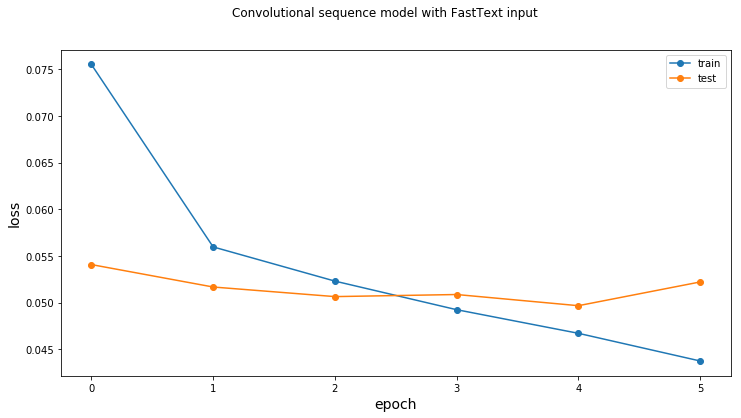

In [39]:
plt.figure(figsize=(12,6))
plt.suptitle("Convolutional sequence model with FastText input")
#plt.subplot(121)
plt.plot(history_CNN.history['loss'],'-o',label='train')
plt.plot(history_CNN.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

In [40]:
np.min(history_CNN.history['val_loss'])

0.049671591895302444

### Try using Figshare Conv layers to initialize model...

In [51]:
figshare_cnn_model = load_model("figshare_rating_cnn")

In [66]:
figshare_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 300)          12386100  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 64)           134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [75]:
figshare_frst8layers = figshare_cnn_model.get_layer('dense_5').output

In [76]:
Conv_FS_output = Dense(6, activation="sigmoid")(figshare_frst8layers)

In [77]:
cnn_fs_model = Model(inputs=figshare_cnn_model.input, outputs=Conv_FS_output)
cnn_fs_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_fs_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 300)          12386100  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 64)           134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [79]:
history_figshare_CNN = cnn_fs_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 442s - loss: 0.0744 - acc: 0.9767 - val_loss: 0.0593 - val_acc: 0.9801
Epoch 2/6
76680/76680 [==============================] - 456s - loss: 0.0610 - acc: 0.9797 - val_loss: 0.0674 - val_acc: 0.9788
Epoch 3/6
76680/76680 [==============================] - 3258s - loss: 0.0549 - acc: 0.9812 - val_loss: 0.0572 - val_acc: 0.9803
Epoch 4/6
76680/76680 [==============================] - 447s - loss: 0.0499 - acc: 0.9824 - val_loss: 0.0635 - val_acc: 0.9796
Epoch 5/6
76680/76680 [==============================] - 449s - loss: 0.0457 - acc: 0.9835 - val_loss: 0.0643 - val_acc: 0.9778
Epoch 6/6
76680/76680 [==============================] - 451s - loss: 0.0422 - acc: 0.9844 - val_loss: 0.0614 - val_acc: 0.9795


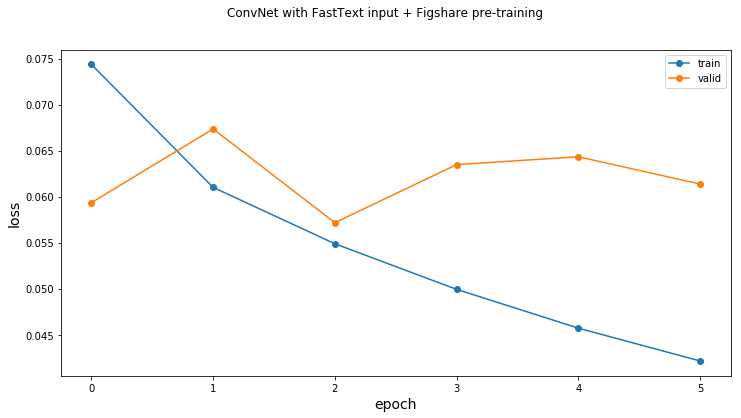

In [83]:
plt.figure(figsize=(12,6))
plt.suptitle("ConvNet with FastText input + Figshare pre-training")
#plt.subplot(121)
plt.plot(history_figshare_CNN.history['loss'],'-o',label='train')
plt.plot(history_figshare_CNN.history['val_loss'],'-o',label='valid')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

Well... that didn't seem to help at all. Moving on!

### LSTM model
Keep same architecture as w2v experiment

In [84]:
MAX_SEQ_LENGTH

200

In [85]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=MAX_SEQ_LENGTH
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [87]:
recurrent_layer = Bidirectional(LSTM(30, return_sequences=True))(embed_seq_unmasked) #dropout=0.1, recurrent_dropout=0.1
recurrent_layer = GlobalMaxPool1D()(recurrent_layer)
recurrent_layer = Dropout(0.5)(recurrent_layer)

In [89]:
rnn_dense = Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(recurrent_layer)
rnn_output = Dense(6, activation="sigmoid")(rnn_dense)

In [91]:
lstm_model = Model(inputs=sequence_input, output=rnn_output)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 300)          12386100  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 60)           79440     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                976       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 102       
Total para

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [94]:
%%time
history_LSTM = lstm_model.fit(seq_train,labels_train
                           ,epochs=3
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/3
76680/76680 [==============================] - 2688s - loss: 0.0605 - acc: 0.9794 - val_loss: 0.0498 - val_acc: 0.9816
Epoch 2/3
76680/76680 [==============================] - 2674s - loss: 0.0521 - acc: 0.9816 - val_loss: 0.0487 - val_acc: 0.9820
Epoch 3/3
76680/76680 [==============================] - 2644s - loss: 0.0491 - acc: 0.9822 - val_loss: 0.0457 - val_acc: 0.9828
CPU times: user 4h 7min 29s, sys: 1h 45min 12s, total: 5h 52min 42s
Wall time: 2h 13min 26s


In [95]:
lstm_model.save("fasttext300_lstm30")

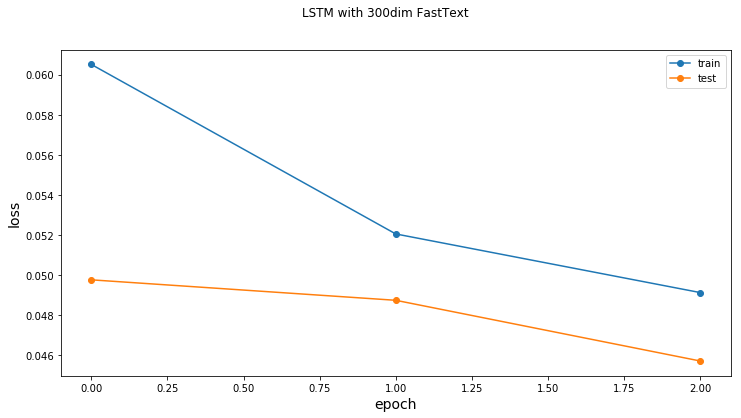

In [96]:
plt.figure(figsize=(12,6))
plt.suptitle("LSTM with 300dim FastText")
plt.plot(history_LSTM.history['loss'],'-o',label='train')
plt.plot(history_LSTM.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

### Kaggle evaluation set scoring

In [97]:
tokenized_test = []
for line in test_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_test += [line_token_idx]

In [98]:
tokenized_test_padded = pad_sequences(tokenized_test,maxlen=200)

In [99]:
lstm_kaggle_predict = lstm_model.predict(tokenized_test_padded)

In [125]:
np.mean(lstm_kaggle_predict,axis=0)

array([0.04081488, 0.00389366, 0.0196001 , 0.0017752 , 0.01845872,
       0.00375234], dtype=float32)

In [100]:
kaggle_submit = pd.DataFrame(lstm_kaggle_predict)
print(kaggle_submit.shape)
kaggle_submit.columns = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

(226998, 6)


In [101]:
kaggle_submit['id'] = testdat['id']
kaggle_submit = kaggle_submit[['id','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
kaggle_submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.002642,6.342337e-06,0.000332,0.000040,0.000257,0.000083
1,6102620,0.001030,9.776885e-07,0.000139,0.000009,0.000089,0.000024
2,14563293,0.000930,9.055578e-07,0.000134,0.000008,0.000077,0.000020
3,21086297,0.002222,8.856232e-06,0.000271,0.000050,0.000200,0.000081
4,22982444,0.006696,5.631140e-05,0.000949,0.000234,0.000782,0.000344


In [103]:
kaggle_submit.to_csv("../300fasttext_bilstm_3e_submit.csv",index=False)

## Evaluate and score on new competition datasets

We have a new training and test set! Time to see how my best existing model does on it..

In [108]:
# Read in new training set
full_train = pd.read_csv('../train.csv')
full_train.shape

(159571, 8)

In [109]:
labels = np.array(full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']])

In [110]:
comments=full_train['comment_text'].tolist()

In [111]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

In [112]:
# Read in test data
testdat = pd.read_csv('../test.csv')
testdat.shape

(153164, 2)

In [113]:
test_comments0 = testdat['comment_text'].tolist()

In [114]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1  

In [116]:
# Tokenized corpus
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [117]:
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

In [118]:
predict_new_train = lstm_model.predict(tokenized_corpus_padded)

In [126]:
np.mean(predict_new_train,axis=0)

array([0.09455352, 0.01146149, 0.0535958 , 0.00424603, 0.05066519,
       0.01010244], dtype=float32)

In [122]:
tokenized_test = []
for line in test_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_test += [line_token_idx]

In [123]:
tokenized_test_padded = pad_sequences(tokenized_test,maxlen=200)

In [127]:
lstm_kaggle_predict = lstm_model.predict(tokenized_test_padded)

In [128]:
np.mean(lstm_kaggle_predict,axis=0)

array([0.21327764, 0.02350517, 0.12829877, 0.00956312, 0.11544549,
       0.02125325], dtype=float32)

In [129]:
kaggle_submit = pd.DataFrame(lstm_kaggle_predict)
print(kaggle_submit.shape)
kaggle_submit.columns = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

(153164, 6)


In [130]:
kaggle_submit['id'] = testdat['id']
kaggle_submit = kaggle_submit[['id','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
kaggle_submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997193,0.421062,0.958760,0.102458,0.929780,0.356530
1,0000247867823ef7,0.001712,0.000004,0.000211,0.000025,0.000148,0.000048
2,00013b17ad220c46,0.002728,0.000013,0.000360,0.000066,0.000264,0.000108
3,00017563c3f7919a,0.001460,0.000002,0.000196,0.000013,0.000133,0.000033
4,00017695ad8997eb,0.007627,0.000067,0.000982,0.000284,0.000899,0.000394


In [133]:
testdat.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic w...
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I sh..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [134]:
kaggle_submit.to_csv("../300fasttext_bilstm_3e_submit.csv",index=False)

### New leaderboard stats: score = 0.069, rank = 153

## Re-train model(s) with new dataset

#### Make sequences for new traindat with now larger vocabulary

In [137]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

In [138]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()
token_count.to_csv('../token_count.csv',index=False)

In [139]:
reduced_token_count = token_count[token_count['freq']>=5]
reduced_token_set = set(reduced_token_count['token'])
reduced_token_count.shape

(66089, 3)

In [140]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token).to_dict()

In [142]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [ ]:
MAX_SEQ_LENGTH=200
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

#### Load re-trained FastText embeddings

In [136]:
fasttext_model = gensim.models.Word2Vec.load("../wiki_fasttext_embed")

In [143]:
print(len(fasttext_model.wv.vocab))
print(reduced_token_count.shape)

66089
(66089, 3)


In [144]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=300
print((V,EMBEDDING_DIM))

(66090, 300)


In [145]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = fasttext_model.wv[token]
    
embed_matrix.shape    

(66090, 300)

#### Training/Validation split

In [146]:
labels0,tokenized_corpus_padded0 = shuffle(labels,tokenized_corpus_padded)

In [147]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [148]:
labels_train,labels_valid, \
seq_train,seq_valid  = \
train_test_split(labels0,tokenized_corpus_padded0,\
                 test_size=0.2,stratify=clean_comment)

#### Try CNN approach

In [165]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=MAX_SEQ_LENGTH
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [166]:
# Convolutional layers: width 7
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(embed_seq_unmasked)
Conv7_layer = MaxPooling1D(2)(Conv7_layer)
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(Conv7_layer)
Conv7_layer = GlobalMaxPool1D()(Conv7_layer)
Conv7_layer = Dropout(0.5)(Conv7_layer)

In [167]:
Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(Conv7_layer)
Conv_output = Dense(6, activation="sigmoid")(Conv_dense)

In [168]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 300)          19827000  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 200, 64)           134464    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 100, 64)           28736     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
__________

In [169]:
%%time
history_CNN = cnn_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 127656 samples, validate on 31915 samples
Epoch 1/6
127656/127656 [==============================] - 742s - loss: 0.1000 - acc: 0.9710 - val_loss: 0.0728 - val_acc: 0.9771
Epoch 2/6
127656/127656 [==============================] - 751s - loss: 0.0720 - acc: 0.9774 - val_loss: 0.0680 - val_acc: 0.9784
Epoch 3/6
127656/127656 [==============================] - 751s - loss: 0.0637 - acc: 0.9793 - val_loss: 0.0665 - val_acc: 0.9790
Epoch 4/6
127656/127656 [==============================] - 753s - loss: 0.0569 - acc: 0.9810 - val_loss: 0.0661 - val_acc: 0.9792
Epoch 5/6
127656/127656 [==============================] - 755s - loss: 0.0515 - acc: 0.9825 - val_loss: 0.0654 - val_acc: 0.9788
Epoch 6/6
127656/127656 [==============================] - 756s - loss: 0.0470 - acc: 0.9834 - val_loss: 0.0691 - val_acc: 0.9795
CPU times: user 3h 29min 31s, sys: 17min 21s, total: 3h 46min 53s
Wall time: 1h 15min 17s


0.06537000842785809


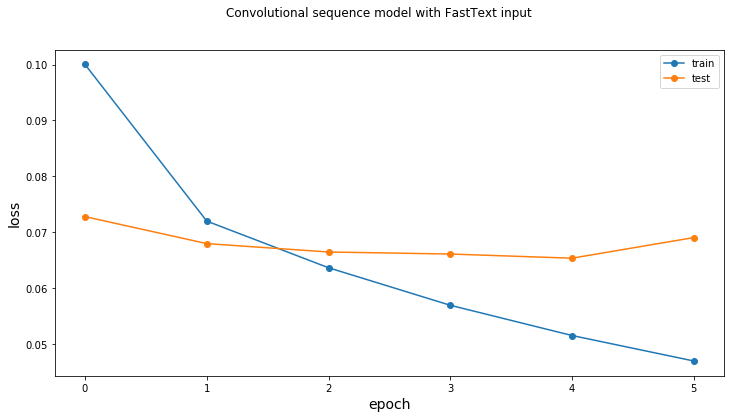

In [171]:
plt.figure(figsize=(12,6))
plt.suptitle("Convolutional sequence model with FastText input")
#plt.subplot(121)
plt.plot(history_CNN.history['loss'],'-o',label='train')
plt.plot(history_CNN.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
print(np.min(history_CNN.history['val_loss']))

In [173]:
cnn0_kaggle_predict = cnn_model.predict(tokenized_test_padded)

In [174]:
np.mean(cnn0_kaggle_predict,axis=0)

array([0.16212028, 0.0148763 , 0.09891274, 0.00466316, 0.08178195,
       0.01252144], dtype=float32)

In [175]:
cnn0_kaggle_submit = pd.DataFrame(cnn0_kaggle_predict)
print(cnn0_kaggle_submit.shape)
cnn0_kaggle_submit.columns = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

(153164, 6)


In [176]:
cnn0_kaggle_submit['id'] = testdat['id']
cnn0_kaggle_submit = cnn0_kaggle_submit[['id','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
cnn0_kaggle_submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.990124,9.543730e-02,0.916704,0.023617,0.683666,0.087208
1,0000247867823ef7,0.003061,3.983565e-07,0.000354,0.000017,0.000203,0.000038
2,00013b17ad220c46,0.010768,5.045474e-06,0.001379,0.000105,0.000907,0.000193
3,00017563c3f7919a,0.000845,3.000467e-08,0.000075,0.000002,0.000037,0.000006
4,00017695ad8997eb,0.001496,9.388794e-08,0.000141,0.000006,0.000069,0.000013


In [177]:
cnn0_kaggle_submit.to_csv("../300fasttext_cnn_6e_submit.csv",index=False)

### Try bidirectional GRU model

In [179]:
gru_layer = Bidirectional(GRU(30, return_sequences=True))(embed_seq_unmasked) #dropout=0.1, recurrent_dropout=0.1
gru_layer = GlobalMaxPool1D()(gru_layer)
gru_layer = Dropout(0.5)(gru_layer)

In [183]:
gru_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(gru_layer)
gru_output = Dense(6, activation="sigmoid")(gru_dense)

In [186]:
gru_model = Model(inputs=sequence_input, output=gru_output)
gru_model.compile(loss='binary_crossentropy'
                  ,  optimizer=RMSprop(clipvalue=1, clipnorm=1)
                  , metrics=['accuracy'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 300)          19827000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 60)           59580     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 60)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1952      
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 198       
Total para

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [188]:
%%time
history_GRU = gru_model.fit(seq_train,labels_train
                           ,epochs=3
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 3553s - loss: 0.0782 - acc: 0.9765 - val_loss: 0.0682 - val_acc: 0.9791
Epoch 2/3
127656/127656 [==============================] - 3575s - loss: 0.0701 - acc: 0.9784 - val_loss: 0.0628 - val_acc: 0.9794
Epoch 3/3
127656/127656 [==============================] - 3552s - loss: 0.0674 - acc: 0.9791 - val_loss: 0.0614 - val_acc: 0.9800
CPU times: user 5h 33min 9s, sys: 2h 19min 55s, total: 7h 53min 5s
Wall time: 2h 58min 2s


0.06142397520871964


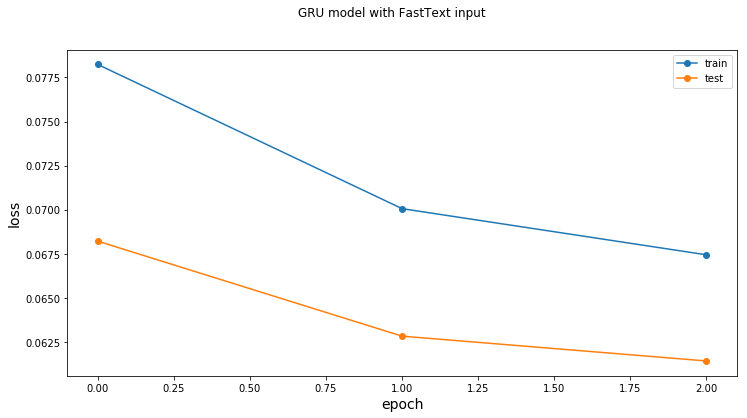

In [189]:
plt.figure(figsize=(12,6))
plt.suptitle("GRU model with FastText input")
#plt.subplot(121)
plt.plot(history_GRU.history['loss'],'-o',label='train')
plt.plot(history_GRU.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
print(np.min(history_GRU.history['val_loss']))

In [191]:
gru0_kaggle_predict = gru_model.predict(tokenized_test_padded)
np.mean(gru0_kaggle_predict,axis=0)

# array([0.21327764, 0.02350517, 0.12829877, 0.00956312, 0.11544549,
#        0.02125325], dtype=float32)

array([0.18621786, 0.02510684, 0.11991216, 0.00329145, 0.10445659,
       0.0196613 ], dtype=float32)

In [192]:
gru0_kaggle_predict = pd.DataFrame(gru0_kaggle_predict)
print(gru0_kaggle_predict.shape)
gru0_kaggle_predict.columns = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

(153164, 6)


In [193]:
gru0_kaggle_predict['id'] = testdat['id']
gru0_kaggle_predict = gru0_kaggle_predict[['id','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
gru0_kaggle_predict.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.984398,9.895848e-02,0.857563,6.431170e-03,0.699597,7.619186e-02
1,0000247867823ef7,0.022400,1.546131e-10,0.001749,8.434111e-11,0.001357,7.334733e-07
2,00013b17ad220c46,0.015984,2.799081e-11,0.000938,3.822871e-11,0.000932,5.508666e-07
3,00017563c3f7919a,0.005864,1.079217e-13,0.000214,9.471937e-14,0.000167,1.101791e-08
4,00017695ad8997eb,0.056442,3.102770e-08,0.006304,3.898164e-08,0.006671,3.312790e-05


In [194]:
gru0_kaggle_predict.to_csv("../300fasttext_bigru_6e_submit.csv",index=False)